JanataHack - E-Commerce Analytics ML Hackathon

Gender Prediction for E-Commerce
With the evolution of the information and communication technologies and the rapid growth of the Internet for the exchange and distribution of information, Electronic Commerce (e-commerce) has gained massive momentum globally, and attracted more and more worldwide users overcoming the time constraints and distance barriers.

It is important to gain in-depth insights into e-commerce via data-driven analytics and identify the factors affecting product sales, the impact of characteristics of customers on their purchase habits.

It is quite useful to understand the demand, habits, concern, perception, and interest of customers from the clue of genders for e-commerce companies. 

However, the genders of users are in general unavailable in e-commerce platforms. To address this gap the aim here is to predict the gender of e-commerce’s participants from their product viewing records.

# Data Dictionary 
Train file: CSV containing the product viewing data with gender as label

#Variable	Definition
#session_id	Session ID
#startTime	Start time of the session
#endTime	End Time of the session
#ProductList	List of products viewed
#gender	(Target) male/female


Product list contains list of products viewed by the user in the given session and it also contains the category, sub category, sub-sub category and the product all encoded and separated with a slash symbol. Each consecutive product is separated with a semicolon.

In [1]:
# import standard libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm,accuracy_score 
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from datetime import timedelta as td 
from time import *

%matplotlib inline

In [2]:
# read the training set and explore first few records

train = pd.read_csv('train_8wry4cB.csv')
train.head()

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male


In [3]:
# read the test set and explore first few records

test = pd.read_csv('test_Yix80N0.csv')
test.head()

,session_id,startTime,endTime,ProductList
0,u12112,08/12/14 13:36,08/12/14 13:36,A00002/B00003/C00006/D19956/
1,u19725,19/12/14 13:52,19/12/14 13:52,A00002/B00005/C00067/D02026/
2,u11795,01/12/14 10:44,01/12/14 10:44,A00002/B00002/C00004/D12538/
3,u22639,08/12/14 20:19,08/12/14 20:22,A00002/B00003/C00079/D22781/;A00002/B00003/C00...
4,u18034,15/12/14 19:33,15/12/14 19:33,A00002/B00001/C00010/D23419/


In [4]:
# preprocess the test data set for prediction

test.startTime = pd.to_datetime(test['startTime'])
test.endTime = pd.to_datetime(test['endTime'])
test.isnull().sum()

session_id     0
startTime      0
endTime        0
ProductList    0
dtype: int64

In [5]:
# read the submission set and explore first few records

subm = pd.read_csv('sample_submission_opxHi4g.csv')
subm.head()

,session_id,gender
0,u12112,female
1,u19725,male
2,u11795,female
3,u22639,female
4,u18034,male


In [6]:
# check the train set structure
train.dtypes

session_id     object
startTime      object
endTime        object
ProductList    object
gender         object
dtype: object

In [7]:
#convert the start and end time to date time

train.startTime = pd.to_datetime(train['startTime'])
train.endTime = pd.to_datetime(train['endTime'])
train.dtypes

session_id             object
startTime      datetime64[ns]
endTime        datetime64[ns]
ProductList            object
gender                 object
dtype: object

In [8]:
#check the shape of train set
train.shape

(10500, 5)

In [9]:
#check for null in the training set
train.isnull().sum()

session_id     0
startTime      0
endTime        0
ProductList    0
gender         0
dtype: int64

In [10]:
# gender distribution in the overall data set
train['gender'].value_counts('Normalize')

female    0.78019
male      0.21981
Name: gender, dtype: float64

In [11]:
train.startTime.min(),train.startTime.max()

(Timestamp('2014-01-12 00:07:00'), Timestamp('2014-12-22 23:54:00'))

In [12]:
train.endTime.min(),train.endTime.max()

(Timestamp('2014-01-12 00:21:00'), Timestamp('2014-12-22 23:54:00'))

In [13]:
test.startTime.min(),test.startTime.max()

(Timestamp('2014-01-12 07:27:00'), Timestamp('2014-12-22 23:13:00'))

In [14]:
test.endTime.min(),test.endTime.max()

(Timestamp('2014-01-12 07:27:00'), Timestamp('2014-12-22 23:16:00'))

In [15]:
#explore the product list for few sessions
strn = train['ProductList'][3].split(';')
strn[0][21:27]


'D10284'

In [16]:
def prodcount(data) :
    strn = (data.split(';'))
    return len(strn)

In [17]:
prodcount(train.iloc[3,3])

3

In [18]:
train['ProductList'][30]

'A00002/B00004/C00012/D08575/'

In [19]:
train['ProductList'][1000]

'A00003/B00020/C00052/D12718/'

In [20]:
# category         - 6 characters alphanumeric code
# Sub Category     - 6 caharacter alphanumeric code
# Sub Sub Category - 6 character  alphanumeric code
# Product          - 6 character  alphanumeric code

# We will extract 2 new features from this, 1 uniquqe string on 18 character
# (to mark cat/sub cat/sub sub cat) and another string of 6 charecter to mark the unique products

# first find the total no of distinct category and products
train['ProductCount'] = [prodcount(x) for x in train['ProductList'] ]
test['ProductCount'] = [prodcount(x) for x in test['ProductList'] ]

In [ ]:
# return days from timedelta
def getdaydur(td) :
    return td.days

In [ ]:
# return hours from timedelta
def gethrsdur(td) :
    return td.seconds / 3600

In [ ]:
# return minutes from timedelta
def getmindur(td) :
    return  (td.seconds /60) % 60

In [21]:
train['duration'] = (train['endTime'] - train['startTime'])

In [22]:
test['duration'] = (test['endTime'] - test['startTime'])

In [26]:
#train['days_duration'] = [getdaydur(x) for x in train['duration'] ]

In [27]:
train['hours_duration'] = [gethrsdur(x) for x in train['duration'] ]

In [28]:
train['minutes_duration'] = [getmindur(x) for x in train['duration'] ]

In [29]:
test['hours_duration'] = [gethrsdur(x) for x in test['duration'] ]

In [30]:
test['minutes_duration'] = [getmindur(x) for x in test['duration'] ]

In [41]:
train_female = train[train.gender == 'female']
train_female.head()

,session_id,startTime,endTime,ProductList,gender,ProductCount,duration,hours_duration,minutes_duration
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female,4,00:01:00,0.016667,1.0
2,u19037,2014-01-12 15:58:00,2014-01-12 15:58:00,A00002/B00001/C00020/D16944/,female,1,00:00:00,0.000000,0.0
3,u14556,2014-11-23 02:57:00,2014-11-23 03:00:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female,3,00:03:00,0.050000,3.0
5,u20964,2014-12-12 15:31:00,2014-12-12 15:31:00,A00002/B00002/C00081/D25039/,female,1,00:00:00,0.000000,0.0
6,u20981,2014-05-12 19:33:00,2014-05-12 19:34:00,A00002/B00011/C00180/D18487/;A00002/B00011/C00...,female,2,00:01:00,0.016667,1.0


In [42]:
train_male = train[train.gender == 'male']
train_male.head()

,session_id,startTime,endTime,ProductList,gender,ProductCount,duration,hours_duration,minutes_duration
1,u10253,2014-12-16 14:35:00,2014-12-16 14:41:00,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male,7,00:06:00,0.100000,6.0
4,u24295,2014-12-17 16:44:00,2014-12-17 16:46:00,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male,2,00:02:00,0.033333,2.0
7,u15947,2014-09-12 16:02:00,2014-09-12 16:06:00,A00002/B00001/C00059/D15254/;A00002/B00001/C00...,male,3,00:04:00,0.066667,4.0
8,u18193,2014-11-25 11:55:00,2014-11-25 11:55:00,A00002/B00001/C00010/D06129/,male,1,00:00:00,0.000000,0.0
13,u13018,2014-11-17 20:53:00,2014-11-17 20:53:00,A00001/B00031/C00044/D01652/;A00001/B00031/C00...,male,2,00:00:00,0.000000,0.0


In [148]:
test.head()

,session_id,startTime,endTime,ProductList,ProductCount,duration,hours_duration,minutes_duration
0,u12112,2014-08-12 13:36:00,2014-08-12 13:36:00,A00002/B00003/C00006/D19956/,1,00:00:00,0.00,0.0
1,u19725,2014-12-19 13:52:00,2014-12-19 13:52:00,A00002/B00005/C00067/D02026/,1,00:00:00,0.00,0.0
2,u11795,2014-01-12 10:44:00,2014-01-12 10:44:00,A00002/B00002/C00004/D12538/,1,00:00:00,0.00,0.0
3,u22639,2014-08-12 20:19:00,2014-08-12 20:22:00,A00002/B00003/C00079/D22781/;A00002/B00003/C00...,4,00:03:00,0.05,3.0
4,u18034,2014-12-15 19:33:00,2014-12-15 19:33:00,A00002/B00001/C00010/D23419/,1,00:00:00,0.00,0.0


In [55]:
# extract gender wise product view catalouge
def get_listofprodviewdgender(data) :
    list_view_product = set()
    for ind in data.index :
        #tl = [ ''.join(x.split('/')) for x in train['ProductList'][ind].split(';')]
        tl = [ x for x in train['ProductList'][ind].split(';')]
        for i in tl :
            list_view_product.add(i)
    return list_view_product

In [56]:
# List of products viewed by female
female_view_products = get_listofprodviewdgender(train_female)

In [57]:
#List of products viewed by male
male_view_products =  get_listofprodviewdgender(train_male)

In [135]:
# identify common products , female only products,male only products

common_products = female_view_products.intersection(male_view_products)
female_only     = female_view_products - common_products
male_only       = male_view_products - common_products

In [59]:
len(common_products),len(female_only),len(male_only)

(583, 12526, 3400)

In [ ]:
# No of common viewed products
def cpcount(data) :
    k =0
    for i in data :
        if (i in common_products)  :
            k+=1            
    return k

In [ ]:
# products for female views
def fcount(data) :
    k =0
    for i in data :
        if (i in female_only)  :
            k+=1            
    return k

In [ ]:
# products for male view
def mcount(data) :
    k =0
    for i in data :
        if (i in male_only) :
            k+=1            
    return k

In [163]:
# create more features like 
#No of common products view
#No of male items view
#No of female items view

train['cpc'] = [ cpcount(train['ProductList'][index].split(';')) for index in train.index]
train['fpc'] = [ fcount(train['ProductList'][index].split(';')) for index in train.index]
train['mpc'] = [ mcount(train['ProductList'][index].split(';')) for index in train.index]

In [164]:
# create more deatures from productlist from test data set
test['cpc'] = [ cpcount(test['ProductList'][index].split(';')) for index in test.index]
test['fpc'] = [ fcount(test['ProductList'][index].split(';')) for index in test.index]
test['mpc'] = [ mcount(test['ProductList'][index].split(';')) for index in test.index]

In [85]:
train['ProductList'][0].split(';')

['A00002/B00003/C00006/D28435/',
 'A00002/B00003/C00006/D02554/',
 'A00002/B00003/C00006/D28436/',
 'A00002/B00003/C00006/D28437/']

In [171]:
train[['cpc','fpc','mpc']].head()

,cpc,fpc,mpc
0,0,4,0
1,0,0,7
2,0,1,0
3,0,3,0
4,0,0,2


In [172]:
test[['cpc','fpc','mpc']].head()

,cpc,fpc,mpc
0,0,0,0
1,0,1,0
2,0,1,0
3,0,2,0
4,0,0,0


In [168]:
test.head()

,session_id,startTime,endTime,ProductList,ProductCount,duration,hours_duration,minutes_duration,cpc,fpc,mpc
0,u12112,2014-08-12 13:36:00,2014-08-12 13:36:00,A00002/B00003/C00006/D19956/,1,00:00:00,0.00,0.0,0,0,0
1,u19725,2014-12-19 13:52:00,2014-12-19 13:52:00,A00002/B00005/C00067/D02026/,1,00:00:00,0.00,0.0,0,1,0
2,u11795,2014-01-12 10:44:00,2014-01-12 10:44:00,A00002/B00002/C00004/D12538/,1,00:00:00,0.00,0.0,0,1,0
3,u22639,2014-08-12 20:19:00,2014-08-12 20:22:00,A00002/B00003/C00079/D22781/;A00002/B00003/C00...,4,00:03:00,0.05,3.0,0,2,0
4,u18034,2014-12-15 19:33:00,2014-12-15 19:33:00,A00002/B00001/C00010/D23419/,1,00:00:00,0.00,0.0,0,0,0


In [173]:
# create a dict item to store the products viewed with cat,sub cat and sub sub cat
def prddict(data) :
    pdict = {}
    for i in data.index :
        key = data['session_id'][i]
        #pdict[key] = [ x[21:27] for x in data['ProductList'][i].split(';')]
        pdict[key] = [ ''.join(x.split('/')) for x in data['ProductList'][i].split(';')]
    return pdict

In [174]:
# Label endocing done
pdict = prddict(train)
pdict1 =  prddict(test)

le = preprocessing.LabelEncoder()
oe = preprocessing.OrdinalEncoder()


In [175]:
pdict

{'u16159': ['A00002B00003C00006D28435',
  'A00002B00003C00006D02554',
  'A00002B00003C00006D28436',
  'A00002B00003C00006D28437'],
 'u10253': ['A00001B00009C00031D29404',
  'A00001B00009C00031D02617',
  'A00001B00009C00031D29407',
  'A00001B00009C00031D29410',
  'A00001B00009C00031D29411',
  'A00001B00009C00031D25444',
  'A00001B00009C00031D29418'],
 'u19037': ['A00002B00001C00020D16944'],
 'u14556': ['A00002B00004C00018D10284',
  'A00002B00004C00018D10285',
  'A00002B00004C00018D10286'],
 'u24295': ['A00001B00001C00012D30805', 'A00001B00001C00012D30806'],
 'u20964': ['A00002B00002C00081D25039'],
 'u20981': ['A00002B00011C00180D18487', 'A00002B00011C00114D18459'],
 'u15947': ['A00002B00001C00059D15254',
  'A00002B00001C00059D00900',
  'A00002B00002C00002D02063'],
 'u18193': ['A00002B00001C00010D06129'],
 'u21820': ['A00002B00001C00010D12841', 'A00002B00002C00112D20047'],
 'u13480': ['A00002B00007C00024D02625'],
 'u14242': ['A00002B00002C00002D22971'],
 'u11583': ['A00002B00001C00150D35

In [176]:
pdict1

{'u12112': ['A00002B00003C00006D19956'],
 'u19725': ['A00002B00005C00067D02026'],
 'u11795': ['A00002B00002C00004D12538'],
 'u22639': ['A00002B00003C00079D22781',
  'A00002B00003C00079D22782',
  'A00002B00003C00079D19325',
  'A00002B00003C00079D22786'],
 'u18034': ['A00002B00001C00010D23419'],
 'u11327': ['A00001B00009C00028D13690',
  'A00001B00009C00028D00696',
  'A00001B00031C00044D13693',
  'A00001B00009C00028D13696'],
 'u12768': ['A00001B00031C00044D13454'],
 'u17011': ['A00001B00009C00028D11956'],
 'u13527': ['A00002B00003C00005D26497'],
 'u24492': ['A00001B00001C00019D04978',
  'A00001B00001C00019D03824',
  'A00001B00001C00019D31655',
  'A00001B00001C00019D31656'],
 'u10027': ['A00002B00001C00010D18416'],
 'u15734': ['A00002B00005C00013D02174'],
 'u11242': ['A00004B00049C00083D12236', 'A00004B00013C00117D12237'],
 'u18013': ['A00002B00001C00010D11146',
  'A00002B00001C00010D24512',
  'A00002B00001C00059D24500'],
 'u15322': ['A00002B00001C00019D03089', 'A00002B00001C00020D14329'],

In [177]:
# Extract all the products of train and test data
i = 0
PRDLS = []
for k in pdict :
    for l in pdict[k] :
        PRDLS.append(l)
    #if i > 15 :
    #    break
    #i+=1
#PRDLS.append('D00000')
#print(PRDLS)
    
#oe.fit_transform(pdict.items())

i = 0
PRDLS1 = []
for k in pdict1 :
    for l in pdict1[k] :
        PRDLS1.append(l)

In [178]:
len(PRDLS),len(PRDLS1)

(23251, 10204)

In [179]:
# Label encoding the products from train and test set

labelencoding = le.fit_transform(PRDLS)
labelencoding1 = le.fit_transform(PRDLS1)
#labelencoding[0:4]

In [180]:
labelencoding[0:4]

array([8537, 8092, 8538, 8539], dtype=int64)

In [181]:
labelencoding1[0:4]

array([4277, 5352, 2715, 4878], dtype=int64)

In [182]:
# Label encode the dictionaries of train and test data

i = 0
for k in pdict :
    l = len(pdict[k])
    pdict[k] = labelencoding[i:i+l]
    i+=l
    
i = 0
for k in pdict1 :
    l = len(pdict1[k])
    pdict1[k] = labelencoding1[i:i+l]
    i+=l

In [183]:
# create train df from train dict
pdictdf = pd.DataFrame.from_dict(pdict,orient = 'index')
pdictdf.fillna(0)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
u16159,8537,8092.0,8538.0,8539.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u10253,1357,1319.0,1358.0,1359.0,1360.0,1348.0,1361.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u19037,2907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u14556,9756,9757.0,9758.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u24295,170,171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u20964,7493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u20981,12041,11975.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u15947,3391,3255.0,3966.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u18193,2586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u21820,2650,7542.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
# create test df from test dict
pdictdf1 = pd.DataFrame.from_dict(pdict1,orient = 'index')
pdictdf1.fillna(0)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
u12112,4277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u19725,5352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u11795,2715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u22639,4878,4879.0,4869.0,4880.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u18034,1375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u11327,606,558.0,1111.0,607.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u12768,1110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u17011,602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u13527,4017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u24492,103,99.0,181.0,182.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
train.columns

Index(['session_id', 'startTime', 'endTime', 'ProductList', 'gender',
       'ProductCount', 'duration', 'hours_duration', 'minutes_duration', 'cpc',
       'fpc', 'mpc'],
      dtype='object')

In [186]:
test.columns

Index(['session_id', 'startTime', 'endTime', 'ProductList', 'ProductCount',
       'duration', 'hours_duration', 'minutes_duration', 'cpc', 'fpc', 'mpc'],
      dtype='object')

In [187]:
train_X = train[['session_id', 'startTime', 'endTime','ProductCount','hours_duration','minutes_duration','cpc', 'fpc', 'mpc']]
test_X  = test[['session_id', 'startTime', 'endTime','ProductCount','hours_duration', 'minutes_duration','cpc', 'fpc', 'mpc']]
train_y = train['gender']

In [188]:
# Create more train features

train_X['startHour'] = train_X['startTime'].dt.hour
train_X['startMinute'] = train_X['startTime'].dt.minute
train_X['endHour'] = train_X['endTime'].dt.hour
train_X['endMinute'] = train_X['endTime'].dt.minute
train_X['dayofweek'] = train_X['startTime'].dt.dayofweek
train_X['quarter'] = train_X['startTime'].dt.quarter
train_X['month'] = train_X['startTime'].dt.month
train_X['year'] = train_X['startTime'].dt.year
train_X['dayofyear'] = train_X['startTime'].dt.dayofyear
train_X['dayofmonth'] = train_X['startTime'].dt.day
train_X['weekofyear'] = train_X['startTime'].dt.weekofyear

C:\Users\Kripya\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Kripya\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [189]:
test_X.dtypes

session_id                  object
startTime           datetime64[ns]
endTime             datetime64[ns]
ProductCount                 int64
hours_duration             float64
minutes_duration           float64
cpc                          int64
fpc                          int64
mpc                          int64
dtype: object

In [190]:
# Create more test features

test_X['startHour']    = test_X['startTime'].dt.hour
test_X['startMinute']  = test_X['startTime'].dt.minute
test_X['endHour']      = test_X['endTime'].dt.hour
test_X['endMinute']    = test_X['endTime'].dt.minute
test_X['dayofweek']    = test_X['startTime'].dt.dayofweek
test_X['quarter']      = test_X['startTime'].dt.quarter
test_X['month']        = test_X['startTime'].dt.month
test_X['year']         = test_X['startTime'].dt.year
test_X['dayofyear']    = test_X['startTime'].dt.dayofyear
test_X['dayofmonth']   = test_X['startTime'].dt.day
test_X['weekofyear']   = test_X['startTime'].dt.weekofyear

C:\Users\Kripya\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [191]:
train_X.head()

,session_id,startTime,endTime,ProductCount,hours_duration,minutes_duration,cpc,fpc,mpc,startHour,startMinute,endHour,endMinute,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,4,0.016667,1.0,0,4,0,18,11,18,12,0,4,12,2014,349,15,51
1,u10253,2014-12-16 14:35:00,2014-12-16 14:41:00,7,0.100000,6.0,0,0,7,14,35,14,41,1,4,12,2014,350,16,51
2,u19037,2014-01-12 15:58:00,2014-01-12 15:58:00,1,0.000000,0.0,0,1,0,15,58,15,58,6,1,1,2014,12,12,2
3,u14556,2014-11-23 02:57:00,2014-11-23 03:00:00,3,0.050000,3.0,0,3,0,2,57,3,0,6,4,11,2014,327,23,47
4,u24295,2014-12-17 16:44:00,2014-12-17 16:46:00,2,0.033333,2.0,0,0,2,16,44,16,46,2,4,12,2014,351,17,51


In [192]:
test_X.head()

,session_id,startTime,endTime,ProductCount,hours_duration,minutes_duration,cpc,fpc,mpc,startHour,startMinute,endHour,endMinute,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,u12112,2014-08-12 13:36:00,2014-08-12 13:36:00,1,0.00,0.0,0,0,0,13,36,13,36,1,3,8,2014,224,12,33
1,u19725,2014-12-19 13:52:00,2014-12-19 13:52:00,1,0.00,0.0,0,1,0,13,52,13,52,4,4,12,2014,353,19,51
2,u11795,2014-01-12 10:44:00,2014-01-12 10:44:00,1,0.00,0.0,0,1,0,10,44,10,44,6,1,1,2014,12,12,2
3,u22639,2014-08-12 20:19:00,2014-08-12 20:22:00,4,0.05,3.0,0,2,0,20,19,20,22,1,3,8,2014,224,12,33
4,u18034,2014-12-15 19:33:00,2014-12-15 19:33:00,1,0.00,0.0,0,0,0,19,33,19,33,0,4,12,2014,349,15,51


In [193]:
train_X = train_X.set_index('session_id')
test_X  = test_X.set_index('session_id')

In [194]:
#merge the train dataset with proudts viewed
new_train_X = pdictdf.join(train_X)
new_train_X = new_train_X.fillna(0)
new_train_X.head()

,0,1,2,3,4,5,6,7,8,9,...,startMinute,endHour,endMinute,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
u16159,8537,8092.0,8538.0,8539.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11,18,12,0,4,12,2014,349,15,51
u10253,1357,1319.0,1358.0,1359.0,1360.0,1348.0,1361.0,0.0,0.0,0.0,...,35,14,41,1,4,12,2014,350,16,51
u19037,2907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58,15,58,6,1,1,2014,12,12,2
u14556,9756,9757.0,9758.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,57,3,0,6,4,11,2014,327,23,47
u24295,170,171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44,16,46,2,4,12,2014,351,17,51


In [195]:
new_train_X.columns

Index([                 0,                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,                 10,                 11,
                       12,                 13,                 14,
                       15,                 16,                 17,
                       18,                 19,                 20,
                       21,                 22,                 23,
                       24,                 25,                 26,
                       27,                 28,                 29,
                       30,                 31,                 32,
                       33,                 34,                 35,
              'startTime',          'endTime',     'ProductCount',
         'hours_duration', 'minutes_duration',              'cpc',
                    'fpc',              'mpc',        'startHo

In [196]:
#merge the test dataset with proudts viewed
new_test_X = pdictdf1.join(test_X)
new_test_X = new_test_X.fillna(0)
new_test_X.head()

,0,1,2,3,4,5,6,7,8,9,...,startMinute,endHour,endMinute,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
u12112,4277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,36,13,36,1,3,8,2014,224,12,33
u19725,5352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52,13,52,4,4,12,2014,353,19,51
u11795,2715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44,10,44,6,1,1,2014,12,12,2
u22639,4878,4879.0,4869.0,4880.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19,20,22,1,3,8,2014,224,12,33
u18034,1375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33,19,33,0,4,12,2014,349,15,51


In [197]:
new_test_X.columns

Index([                 0,                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,                 10,                 11,
                       12,                 13,                 14,
                       15,                 16,                 17,
                       18,                 19,                 20,
                       21,                 22,                 23,
                       24,                 25,                 26,
                       27,                 28,                 29,
                       30,                 31,                 32,
                       33,                 34,                 35,
                       36,                 37,                 38,
                       39,                 40,                 41,
                       42,        'startTime',          'endTi

In [198]:
new_test_X.columns = [
    'prod1','prod2','prod3','prod4','prod5','prod6','prod7','prod8','prod9','prod10','prod11',
    'prod12','prod13','prod14','prod15','prod16','prod17','prod18','prod19','prod20','prod21',
    'prod22','prod23','prod24','prod25','prod26','prod27','prod28','prod29','prod30','prod31',
    'prod32','prod33','prod34','prod35','prod36','prod37','prod38','prod39','prod40','prod41',
    'prod42','prod43','startTime','endTime','ProductCount','hours_duration','minutes_duration',
    'cpc', 'fpc', 'mpc','startHour','startMinute','endHour','endMinute','dayofweek','quarter',
    'month','year','dayofyear','dayofmonth','weekofyear']

In [199]:
new_train_X.columns = [
    'prod1','prod2','prod3','prod4','prod5','prod6','prod7','prod8','prod9','prod10','prod11',
    'prod12','prod13','prod14','prod15','prod16','prod17','prod18','prod19','prod20','prod21',
    'prod22','prod23','prod24','prod25','prod26','prod27','prod28','prod29','prod30','prod31',
    'prod32','prod33','prod34','prod35','prod36','startTime','endTime','ProductCount',
    'hours_duration','minutes_duration','cpc', 'fpc', 'mpc','startHour','startMinute','endHour',
    'endMinute','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']

In [200]:
train_y = le.fit_transform(train_y)
train_y

array([0, 1, 0, ..., 0, 0, 0])

In [201]:
new_train_X.shape,train_y.shape

((10500, 55), (10500,))

In [202]:
new_train_X['ProductCount'].value_counts('Normalize')

1     0.530381
2     0.220095
3     0.102381
4     0.053238
5     0.030286
6     0.018762
7     0.012095
8     0.009048
9     0.006286
11    0.003905
10    0.003238
12    0.002190
13    0.001619
15    0.001429
14    0.001048
18    0.000762
16    0.000667
27    0.000381
21    0.000381
20    0.000286
29    0.000286
17    0.000286
19    0.000190
36    0.000190
25    0.000190
22    0.000095
30    0.000095
24    0.000095
35    0.000095
Name: ProductCount, dtype: float64

In [203]:
new_test_X['ProductCount'].value_counts('Normalize')

1     0.525556
2     0.214444
3     0.104000
4     0.050889
5     0.034222
6     0.021556
7     0.017333
8     0.008222
10    0.005111
9     0.004444
11    0.004222
12    0.002000
13    0.001778
14    0.001333
15    0.000889
20    0.000667
17    0.000667
18    0.000444
16    0.000222
28    0.000222
43    0.000222
21    0.000222
25    0.000222
31    0.000222
30    0.000222
23    0.000222
27    0.000222
29    0.000222
Name: ProductCount, dtype: float64

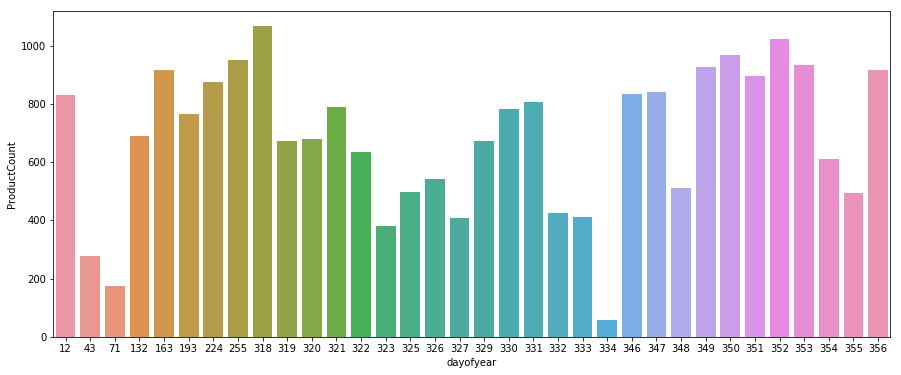

In [204]:
# No of products viewed during the year

plt.figure(figsize = (15,6))
df_doyprodcount = pd.DataFrame(new_train_X.groupby('dayofyear')['ProductCount'].sum())
sns.barplot(df_doyprodcount.index,df_doyprodcount['ProductCount'])

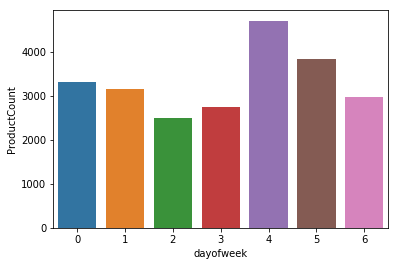

In [205]:
# no of products viewed on a weekday

df_dowprodcount = pd.DataFrame(new_train_X.groupby('dayofweek')['ProductCount'].sum())
sns.barplot(df_dowprodcount.index,df_dowprodcount['ProductCount'])

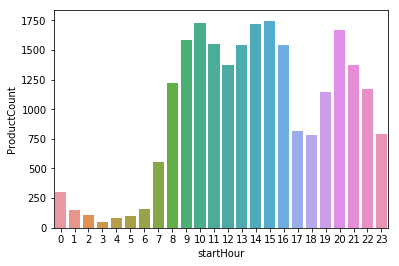

In [206]:
#Hourly total products viewed

df_hourlyprodcount = pd.DataFrame(new_train_X.groupby('startHour')['ProductCount'].sum())
sns.barplot(df_hourlyprodcount.index,df_hourlyprodcount['ProductCount'])

In [521]:
#train_x = new_train_X[[
#    'prod1','prod2','prod3','prod4','prod5','prod6','prod7','prod8','prod9','prod10','prod11',
#    'prod12','prod13','prod14','prod15','prod16','prod17','prod18','prod19','prod20','prod21',
#    'prod22','prod23','prod24','prod25','prod26','prod27','prod28','prod29','prod30','prod31',
#    'prod32','prod33','prod34','prod35','prod36','ProductCount','startHour','startMinute',
#    'endHour','endMinute','dayofweek','quarter','month','year','dayofyear','dayofmonth',
#    'weekofyear']].values
#train_x.shape 

In [208]:
train_x = new_train_X[[
    'prod1','prod2','prod3','ProductCount','hours_duration','minutes_duration','cpc',
    'fpc', 'mpc','startHour','startMinute','endHour','endMinute','dayofweek','dayofyear',
    'weekofyear']].values
train_x.shape

(10500, 16)

In [209]:
train_x1 = new_train_X[[
    'prod1','prod2','prod3','prod4','prod5','ProductCount','hours_duration','minutes_duration',
    'cpc', 'fpc', 'mpc','startHour','startMinute','endHour','endMinute','dayofweek','dayofyear',
    'weekofyear']].values
train_x1.shape

(10500, 18)

In [210]:
# split the dataset into training and validation set

X_train,X_val,y_train,y_val = train_test_split(train_x,train_y,test_size = 0.3,stratify =train_y,random_state = 42)

X_train.shape,X_val.shape,y_train.shape,y_val.shape

((7350, 16), (3150, 16), (7350,), (3150,))

In [211]:
np.count_nonzero(y_train),np.count_nonzero(y_val)

(1616, 692)

In [212]:
1616/7350 , 692/3150

(0.2198639455782313, 0.21968253968253967)

In [213]:
#scale the data
mms = MinMaxScaler()
X_train_scaled = mms.fit_transform(X_train)
X_val_scaled   = mms.transform(X_val)

In [214]:
# model 1  ; Logistic Regression

lr = LogisticRegression()
lr.fit(X_train_scaled,y_train)
LRP = lr.predict(X_val_scaled)
round(accuracy_score(y_val,LRP),2)

C:\Users\Kripya\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.94

In [215]:
LRP

array([1, 0, 0, ..., 0, 0, 0])

In [216]:
cm(y_val,LRP)

array([[2458,    0],
       [ 178,  514]], dtype=int64)

In [225]:
# model 2 : Support Vector
svclf = SVC(kernel = 'sigmoid',gamma='auto')
svclf.fit(X_train_scaled,y_train)
SVP = svclf.predict(X_val_scaled)
round(accuracy_score(y_val,SVP),2)

0.82

In [226]:
cm(y_val,SVP)

array([[2458,    0],
       [ 565,  127]], dtype=int64)

In [227]:
# model 3 : Decision Tree Classifier
dtclf = DecisionTreeClassifier()
dtclf.fit(X_train_scaled,y_train)
DTCP = dtclf.predict(X_val_scaled)
round(accuracy_score(y_val,DTCP),2)

0.97

In [233]:
# model 4 : Extra Tree Classifier
xtclf = ExtraTreeClassifier()
xtclf.fit(X_train_scaled,y_train)
ETCP = xtclf.predict(X_val_scaled)
round(accuracy_score(y_val,ETCP),2)

0.97

In [275]:
# hyper parameter for random forest 

n_estimators = [500,800,1500,2500,5000]
max_features =[3,6,9,12,15]
max_depth = [5,10,15,25]
min_samples_split = [2,5,10,15,20]
min_samples_leaf = [1,2,5,10,15]

grid_param = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth'   : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf'  : min_samples_leaf}

RFR = RandomForestClassifier(random_state =10)
RFR_random = RandomizedSearchCV(estimator = RFR,param_distributions = grid_param,scoring = 'accuracy',
                               n_iter = 5,cv=25,verbose =2,random_state =42,n_jobs =-1)

RFR_random.fit(X_train_scaled,y_train)
print(RFR_random.best_params_)

Fitting 25 folds for each of 5 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  6.9min finished


{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 15, 'max_depth': 10}


In [277]:
# model 5 Random Forest Classifier bagging

rfclf = RandomForestClassifier(n_estimators = 500,criterion = 'gini',max_depth = 15,
            max_features = 15,min_samples_split = 5,random_state = 42)
rfclf.fit(X_train_scaled,y_train)
RFCP = rfclf.predict(X_val_scaled)
round(accuracy_score(y_val,RFCP),2)

0.97

In [264]:
rfclf.feature_importances_

array([0.45316964, 0.0780089 , 0.02516879, 0.0168447 , 0.01587186,
       0.01514473, 0.05025783, 0.07637327, 0.05020334, 0.07675226,
       0.04338084, 0.06842293, 0.0304009 ])

In [243]:
#Perform random grid search for finding the best model
def findbestparamfor(X,y) :
    xgcl = xgb.XGBClassifier(objective ='binary:logistic')

    param_grid = {
        'silent': [False],
        'max_depth': [3,4,5,6,8,10,12,15,20],
        'learning_rate': [0.001, 0.01, 0.1, 0.15,0.2,0.25, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0,0.1, 0.25,0.2,0.3,0.4, 0.5, 1.0],
        'alpha': [0,0.001,0.005,0.01,0.05],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
        ,'n_estimators': [1500]}

    #fit_params = {'eval_metric': 'binary:logistic' }

    
    rs_cls = RandomizedSearchCV(xgcl, param_grid,n_iter=4,scoring = 'accuracy',
                            n_jobs=-1, verbose=2,
                            #fit_params=fit_params,
                            refit=False, cv =10,random_state=42)

    print("Randomized search..")
    search_time_start = time()
   # rs_reg.fit(X, y,early_stopping_rounds =50,eval_set=[(Xval,yval)])
    rs_cls.fit(X,y)
    print("Randomized search time:", time() - search_time_start)

    best_score = rs_cls.best_score_
    best_params = rs_cls.best_params_
    print("Best score: {}".format(best_score))
    print("Best params: ")
    for param_name in sorted(best_params.keys()):
        print('%s: %r' % (param_name, best_params[param_name]))


In [244]:
findbestparamfor(X_train_scaled,y_train)

Randomized search..
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min


Randomized search time: 163.79413032531738
Best score: 0.9756462585034014
Best params: 
alpha: 0.001
colsample_bylevel: 1.0
colsample_bytree: 0.6
gamma: 0
learning_rate: 0.01
max_depth: 5
min_child_weight: 10.0
n_estimators: 1500
reg_lambda: 50.0
silent: False
subsample: 0.5


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.7min finished


In [283]:
#XGBM model

xgclf = xgb.XGBClassifier(objective ='binary:logistic',colsample_bylevel =1.0,
                       colsample_bytree = 0.6,gamma =0,alpha=0.001,learning_rate =0.01,
                       max_depth = 5,min_child_weight = 10.0,n_estimators =1500,
                       reg_lambda =50.0,silent =False,subsample = 0.5)
xgclf.fit(X_train_scaled,y_train)
XGBCP = xgclf.predict(X_val_scaled)
round(accuracy_score(y_val,XGBCP),2)

0.97

In [269]:
nbclf = GaussianNB()
nbclf.fit(X_train_scaled,y_train)
NBCP = nbclf.predict(X_val_scaled)
round(accuracy_score(y_val,NBCP),2)

0.97

In [252]:
cm(y_val,NBCP)

array([[2402,   56],
       [  34,  658]], dtype=int64)

In [268]:
neclf = KNeighborsClassifier(n_neighbors = 3)
neclf.fit(X_train_scaled,y_train)
KNCP = neclf.predict(X_val_scaled)
round(accuracy_score(y_val,KNCP),2)

0.86

In [264]:
cm(y_val,KNCP)

array([[2404,   54],
       [ 395,  297]], dtype=int64)

In [178]:
test.shape

(4500, 8)

In [179]:
test_X = new_test_X[[
    'prod1','prod2','prod3','prod4','prod5','prod6','prod7','prod8','prod9','prod10','prod11',
    'prod12','prod13','prod14','prod15','prod16','prod17','prod18','prod19','prod20','prod21',
    'prod22','prod23','prod24','prod25','prod26','prod27','prod28','prod29','prod30','prod31',
    'prod32','prod33','prod34','prod35','prod36','prod37','prod38','prod39','prod40','prod41',
    'prod42','prod43','ProductCount','startHour','startMinute','endHour',
    'endMinute','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']].values
test_X.shape

(4500, 55)

In [180]:
test_X1 = new_test_X[[
    'prod8','prod9','prod10','prod11',
    'prod12','prod13','prod14','prod15','prod16','prod17','prod18','prod19','prod20','prod21',
    'prod22','prod23','prod24','prod25','prod26','prod27','prod28','prod29','prod30','prod31',
    'prod32','prod33','prod34','prod35','prod36','prod37','prod38','prod39','prod40','prod41',
    'prod42','prod43','ProductCount','startHour','startMinute','endHour',
    'endMinute','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']].values
test_X1.shape

(4500, 48)

In [218]:
test_X2 = new_test_X[[
    'prod1','prod2','prod3','ProductCount','hours_duration','minutes_duration','cpc',
    'fpc', 'mpc','startHour','startMinute','endHour','endMinute','dayofweek','dayofyear',
    'weekofyear']].values
test_X2.shape

(4500, 16)

In [219]:
#X_test_scaled1   = mms.transform(test_X1)
X_test_scaled2   = mms.transform(test_X2)

In [220]:
# Logistic Regression Prediction
LRPT  = lr.predict(X_test_scaled2)
LRPT

array([0, 0, 0, ..., 0, 1, 0])

In [236]:
# Random Forest Classifier Prediction
RFCP = rfclf.predict(X_test_scaled2)
RFCP

array([0, 0, 0, ..., 1, 1, 0])

In [284]:
# xgboost prediction
XGBCP = xgclf.predict(X_test_scaled2)
XGBCP

array([0, 0, 0, ..., 1, 1, 0])

In [228]:
# decision tree classier prediction
DTCP = dtclf.predict(X_test_scaled2)
DTCP

array([1, 0, 0, ..., 1, 1, 0])

In [590]:
# support vector classifier prediction
SVP = svclf.predict(X_test_scaled2)
SVP

array([0, 0, 0, ..., 0, 0, 0])

In [270]:
# naive bayes classifier prediction
NBCP = nbclf.predict(X_test_scaled2)
NBCP

array([0, 0, 0, ..., 1, 1, 0])

In [254]:
#knnclassifier prediction
KNCP = neclf.predict(X_test_scaled2)
KNCP

array([0, 0, 0, ..., 0, 0, 0])

In [285]:
gender = []
for i in XGBCP :
    if i == 0 :
        gender.append('female')
    else :
        gender.append('male')
gender = pd.DataFrame(gender)


In [286]:
subm_lr = subm.drop('gender',1)

In [287]:
subm_lr = pd.concat([subm_lr,gender],axis=1)
col = ['session_id','gender']
subm_lr.columns = col
subm_lr.head()

,session_id,gender
0,u12112,female
1,u19725,female
2,u11795,female
3,u22639,female
4,u18034,male


In [288]:
# submission file output
subm_lr.to_csv(r'E:\Pattabhiraman\Personal\JhackEcomm\XGBCP005.csv',index=False)